In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
import os

In [2]:
#le o dataset de controle de trafego na Web em LA, pegando apenas 3 colunas especificas do arquivo e converte a colunas de "Date" para formato apropriado
data = pd.read_csv(os.path.join('..\..\Dataset\casos_mensais.csv'), delimiter=',',
                   parse_dates=['dt_notificacao']).loc[:, ['dt_notificacao', 'nm_municipio', 'casos']]

Divisão dos dados em treino e validação

In [8]:
#intervalo de dados de treino
train = pd.DataFrame(data.where(data['dt_notificacao'] <= '2019-12-01'))
#intervalo de dados de validação
valid = pd.DataFrame(data.where(data['dt_notificacao'] > '2019-12-01'))
#conta quantos dias distintos tem no conjunto de validação 
# h é a quantidade timestamps(pontos especificos na linha do tempo) que se quer prever no futuro
h = valid['dt_notificacao'].nunique()

In [11]:
#importação da biblioteca utilizada para criar e manipular series temporais
from darts import TimeSeries # type: ignore
#retorna uma lista de todos os dispositivos únicos, para saber quantas series temporais criar
series_names = train['nm_municipio'].unique()
#cria uma serie temporal a partir de um dataframe. 
# Cada série temporal representa a evolução de um valor ao longo do tempo para um grupo específico (neste caso, um tipo de dispositivo)
train_series = TimeSeries.from_group_dataframe(train, time_col='dt_notificacao', value_cols=['casos'], group_cols=['nm_municipio'], freq='D', fill_missing_dates=True, fillna_value=0.)

In [12]:
from darts.models import KalmanForecaster # type: ignore


In [20]:
# Predictions list to store results
preds = list()

# Iterate over each series in train_series
for i, series in enumerate(train_series):
    try:
        print("epoch:", i)

        # Initialize KalmanForecaster with dim_x=1
        model = KalmanForecaster(dim_x=2)

        # Fit the model on the current time series
        model.fit(series=series)

        # Predict future values (h steps ahead)
        p = model.predict(h).pd_dataframe()

        # Keep original date index
        p = p.set_index(series.time_index[-h:])  # Align predictions with the last h dates of series

        # Add the 'nm_municipio' column
        p['nm_municipio'] = series_names[i]

        # Append predictions to list
        preds.append(p)

    except Exception as exp:
        print(f"Error at epoch {i}: {exp}")

# Concatenate predictions and rename 'casos' to 'Predicted'
preds = pd.concat(preds, axis=0, ignore_index=False).rename(columns={'casos': 'Predicted'})

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

In [15]:
#junta os dados r5eais com os dados previstos
preds = preds.merge(train, on=['dt_notificacao', 'nm_municipio'], how='left')
    
    
#usa o MAPE para medir o quao distantes estao os valores dos reais
from sklearn.metrics import mean_absolute_percentage_error # type: ignore
mean_absolute_percentage_error(preds['casos'], preds['Predicted'])

0.6217054263565891

In [16]:
valid['dt_notificacao'].unique()

<DatetimeArray>
[                'NaT', '2020-01-01 00:00:00', '2020-02-01 00:00:00',
 '2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00',
 '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00',
 '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00',
 '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00',
 '2021-06-01 00:00:00', '2021-07-01 00:00:00', '2021-08-01 00:00:00',
 '2021-09-01 00:00:00', '2021-10-01 00:00:00', '2021-11-01 00:00:00',
 '2021-12-01 00:00:00', '2022-01-01 00:00:00', '2022-02-01 00:00:00',
 '2022-03-01 00:00:00', '2022-04-01 00:00:00', '2022-05-01 00:00:00',
 '2022-06-01 00:00:00', '2022-07-01 00:00:00', '2022-08-01 00:00:00',
 '2022-09-01 00:00:00', '2022-10-01 00:00:00', '2022-11-01 00:00:00',
 '2022-12-01 00:00:00', '2023-01-01 00:00:00', '2023-02-01 00:00:00',
 '2023-03-01 00:00:00', '2023-04-01 00:00:00', '2023-05-01 00:00:00',
 '20

In [17]:
preds

,dt_notificacao,Predicted,nm_municipio,casos
0,2019-11-01,0.0,Adamantina,19.0
1,2019-12-01,0.0,Adamantina,21.0
2,2019-11-01,0.0,Adolfo,0.0
3,2019-12-01,0.0,Adolfo,1.0
4,2019-11-01,0.0,Aguaí,17.0
...,...,...,...,...
1285,2019-12-01,0.0,Votorantim,13.0
1286,2019-11-01,0.0,Votuporanga,478.0
1287,2019-12-01,0.0,Votuporanga,885.0
1288,2019-11-01,0.0,Zacarias,0.0


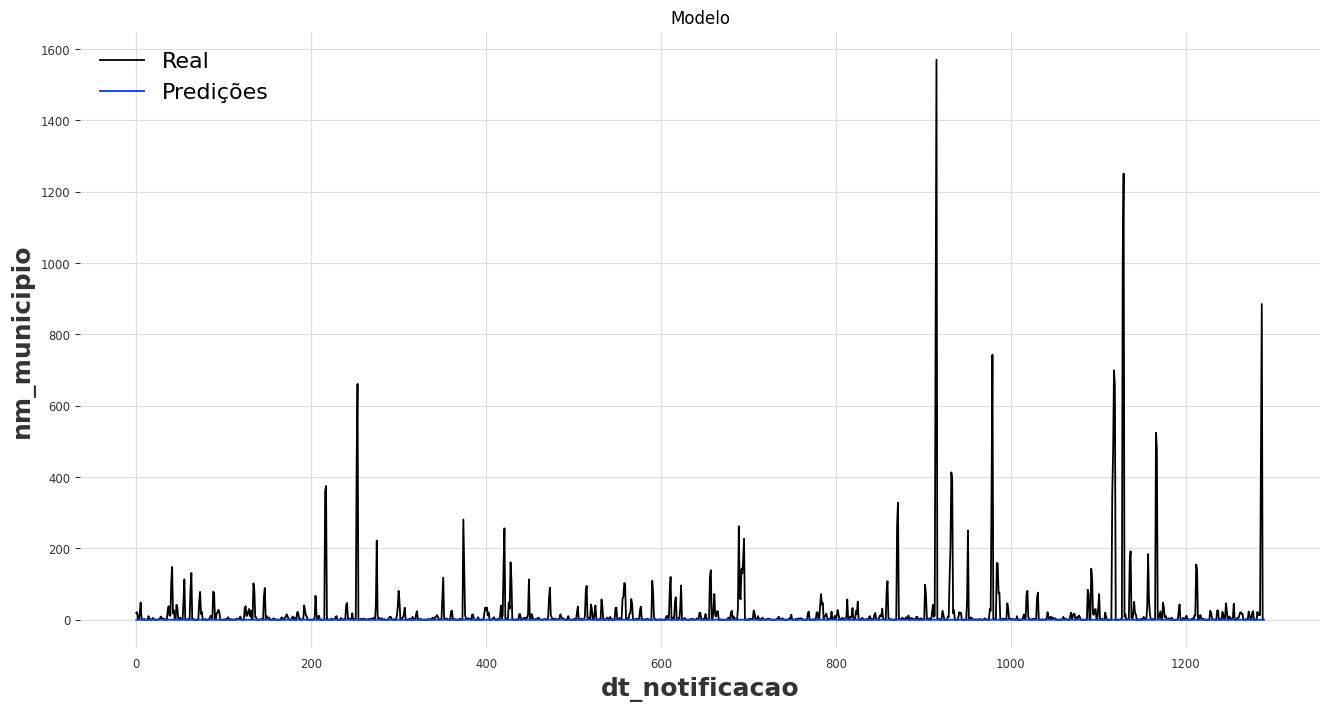

In [18]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('dt_notificacao', fontsize = 18)
plt.ylabel("nm_municipio", fontsize = 18)
plt.plot(preds[['casos']])
plt.plot(preds[['Predicted']])
plt.legend(['Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [50]:
from darts.models import KalmanForecaster

preds = list()
for i, series in enumerate(train_series):
    model = KalmanForecaster(dim_x=100)
    model.fit(series=series)
    p = model.predict(h, num_samples=100)
    p = [p.quantile_df(q) for q in [0.05, 0.5, 0.95]]
    p = pd.concat(p, axis=1).reset_index()
    p['Device Category'] = series_names[i]
    preds.append(p)
preds = pd.concat(preds, axis=0, ignore_index=True)
preds = preds.merge(valid, on=['Date', 'Device Category'], how='left')

C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
C:\Users\asawoi\AppData\Local\Temp\ipykernel_28396\4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

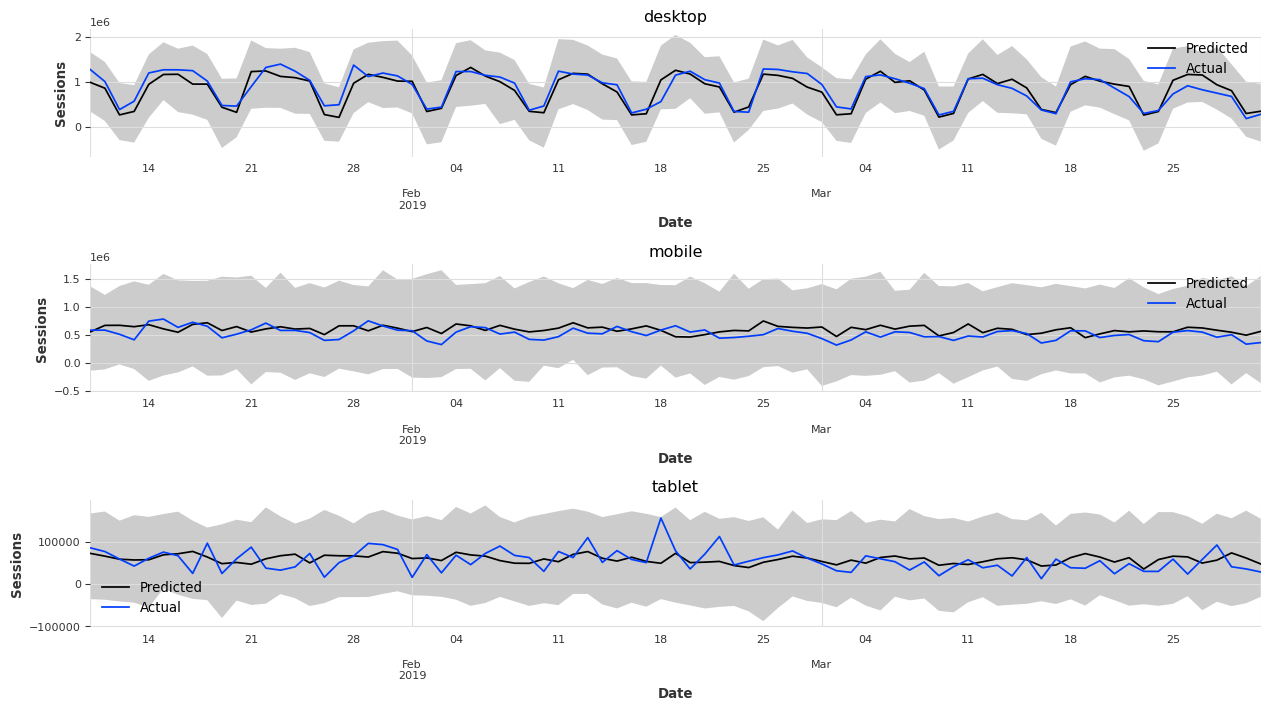

In [51]:
fig,ax = plt.subplots(3,1,figsize=(1280/96, 720/96), dpi=96)
preds_ = preds[preds['Date'] >= '2019-01-10']
for ax_, device in enumerate(preds_['Device Category'].unique()):
    p_ = preds_.loc[preds_['Device Category'] == device]
    p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
    ax[ax_].fill_between(p_['Date'], p_['Sessions_0.05'], p_['Sessions_0.95'], alpha=0.2)
    p_.plot(x='Date', y=['Predicted', 'Actual'], ax=ax[ax_], title=device)
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sessions')
fig.tight_layout()

In [52]:
from sklearn.metrics import mean_pinball_loss
for q in [0.05, 0.5, 0.95]:
    print(f'Pinball loss at {q}: {mean_pinball_loss(preds["Sessions"], preds[f"Sessions_{q}"])}')

Pinball loss at 0.05: 268637.8143807489
Pinball loss at 0.5: 51956.13305713162
Pinball loss at 0.95: 271511.7489896879
